In [55]:
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
from scipy import ndimage
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from math import sqrt

## Task 1 

The watershed is a classical algorithm used for segmentation, which is very useful when extracting touching or overlapping objects in images.

Starting from user-defined markers, the watershed algorithm treats pixels values as a local topography (elevation). The algorithm floods basins from the markers until basins attributed to different markers meet on watershed lines

In [81]:
img = cv.imread('circles.png',0)

In [10]:
#compute the exact Euclidean distance from every binary pixel to the nearest zero pixel, 
#then find peaks in this distance map
distance=ndimage.distance_transform_edt(img)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=img) #yields two points, as local minima

In [17]:
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndimage.label(mask)
labels = watershed(-distance, markers, mask=img)

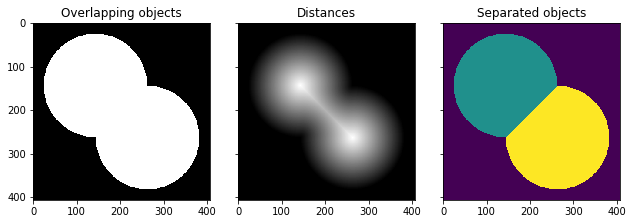

In [29]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, )
ax[2].set_title('Separated objects')

fig.tight_layout()
plt.show()


## Task 2

In general, you need the Fourier transform if you need to look at the frequencies in a signal (gray scaled pixels into frequencies). Digital images, unlike light wave and sound wave in real life, are discrete because pixels are not continuous. That means we should implement Discrete Fourier Transformation (DFT) instead of Fourier Transformation. And Fast Fourier Transformation (FFT) is faster and more practical to do the digital image processing.


In [31]:
img = cv.imread('building.png',0)

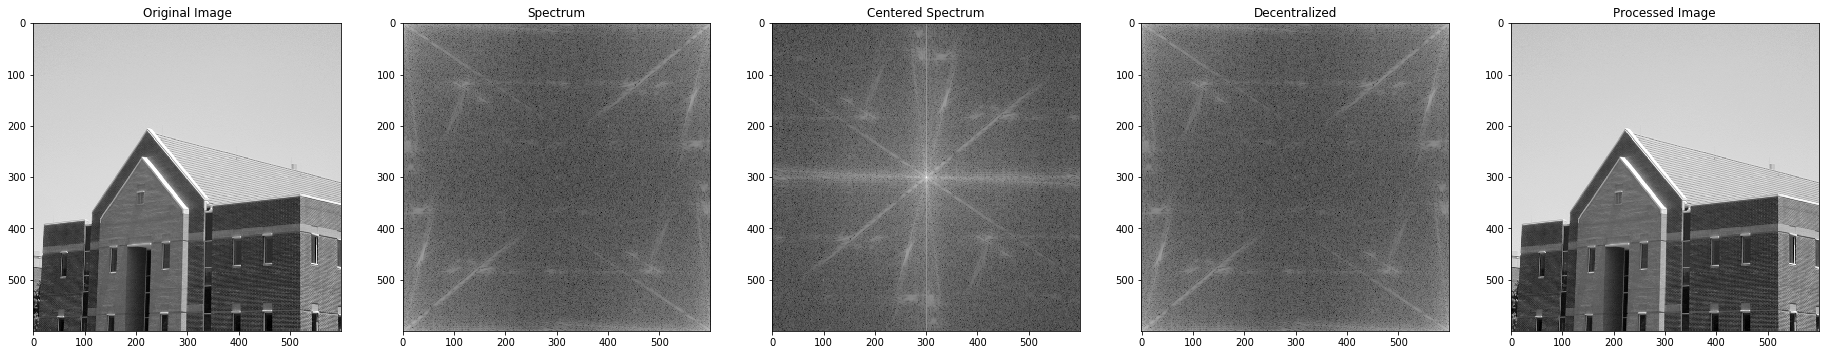

In [41]:
img_c2 = np.fft.fft2(img) #Compute the 2-dimensional Fast Fourier Transform
img_c3 = np.fft.fftshift(img_c2) #Shift the zero-frequency component to the center of the spectrum
img_c4 = np.fft.ifftshift(img_c3) #Inverse of Step 2. Shift the zero-frequency component back to original location
img_c5 = np.fft.ifft2(img_c4) #Inverse of Step 1. Compute the 2-dimensional inverse Fast Fourier Transform

plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
plt.subplot(151), plt.imshow(img, "gray"), plt.title("Original Image")
plt.subplot(152), plt.imshow(np.log(1+np.abs(img_c2)), "gray"), plt.title("Spectrum")
plt.subplot(153), plt.imshow(np.log(1+np.abs(img_c3)), "gray"), plt.title("Centered Spectrum")
plt.subplot(154), plt.imshow(np.log(1+np.abs(img_c4)), "gray"), plt.title("Decentralized")
plt.subplot(155), plt.imshow(np.abs(img_c5), "gray"), plt.title("Processed Image")
fig.tight_layout()
plt.show()

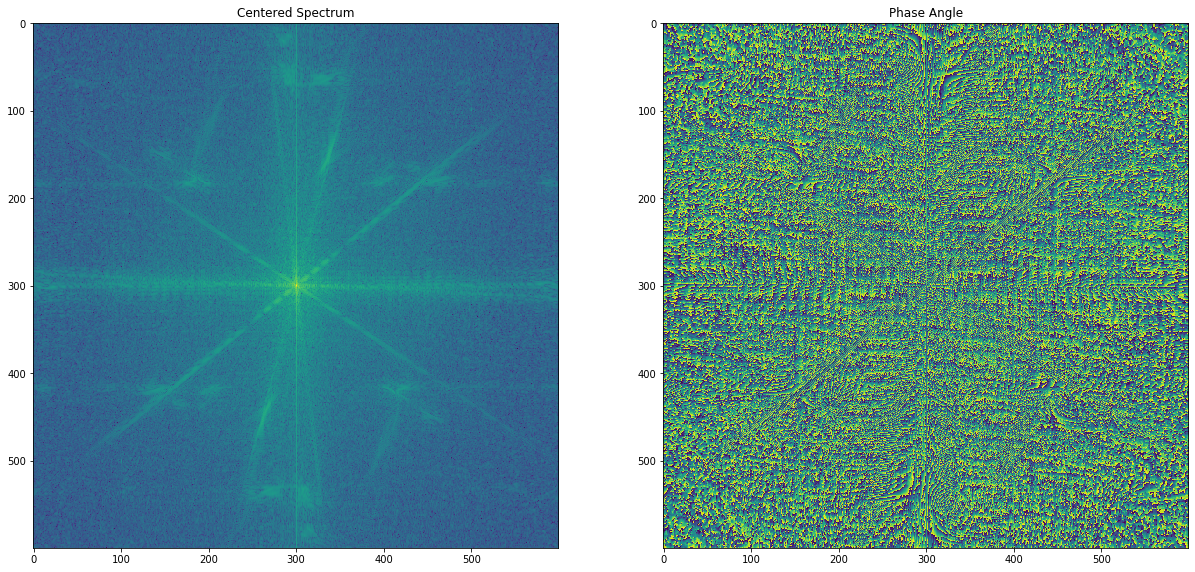

In [51]:
original = np.fft.fft2(img)
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
plt.subplot(131), plt.imshow(np.abs(np.log(img_c3)), ), plt.title("Centered Spectrum")
plt.subplot(132), plt.imshow(np.angle(img_c3), ), plt.title("Phase Angle")

plt.show()

The white area in the spectrum image show the high power of frequency. The corners in the spectrum image represent low frequencies. Therefore, combining two points above, the white area on the corner indicates that there is high energy in low/zero frequencies which is a very normal situation for most images. Later, it is often shifted the zero-frequency component to the center of the spectrum which makes the spectrum image more visible for human. On the other side, it is hard to identify any noticeable patterns from Phase Angle, though the phase preserves the shape characteristics which is an indispensable information for an image

## Task 3

In [94]:
img = cv.imread('test_pattern.png',0)

Low pass filter is a filter that only allow low frequencies to pass through. Low frequencies in images mean pixel values that are changing slowly. For example, smooth area with slightly color changing in the image such as the background is considered as a low frequency content.
The high frequencies contents such as noises are blocked which make processed image has less noisy pixels. Therefore, low pass filter is highly used to remove the noises in images.

High Pass filter, on the contrary, is a filter that only allow high frequencies to pass through. High frequencies in images mean pixel values that are changing dramatically. For example, Edge areas in the image with huge color changing are considered as the high frequency content.
The output from high pass filter captures the edges in image which could be used to sharpen the original image with proper overlap calculation. This will enhance sharpness in original image making edges more clear.

The idea which behinds ideal filter is very simple: Given a radius value D₀ as a threshold, low pass filter has H(u, v) equals to 1 under the threshold, and H(u, v) equals to 0 when above the threshold. On the contrary, high pass filter has H(u, v) equals to 0 under threshold, and H(u, v) equals to 1 when above the threshold

https://miro.medium.com/max/538/1*SckaHFSMmrH40uvJggK6Rg.png


In [53]:
#Ideal Filter
def distance(point1,point2):
    return sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def idealFilterLP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            if distance((y,x),center) < D0:
                base[y,x] = 1
    return base

def idealFilterHP(D0,imgShape):
    base = np.ones(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            if distance((y,x),center) < D0:
                base[y,x] = 0
    return base

In [95]:
original = np.fft.fft2(img)
center = np.fft.fftshift(original)

LowPassCenter = center * idealFilterLP(30,img.shape)
LowPass = np.fft.ifftshift(LowPassCenter)
inverse_LowPass = np.fft.ifft2(LowPass)

In [98]:
HighPassCenter = center * idealFilterHP(50,img.shape)
HighPass = np.fft.ifftshift(HighPassCenter)
inverse_HighPass = np.fft.ifft2(HighPass)


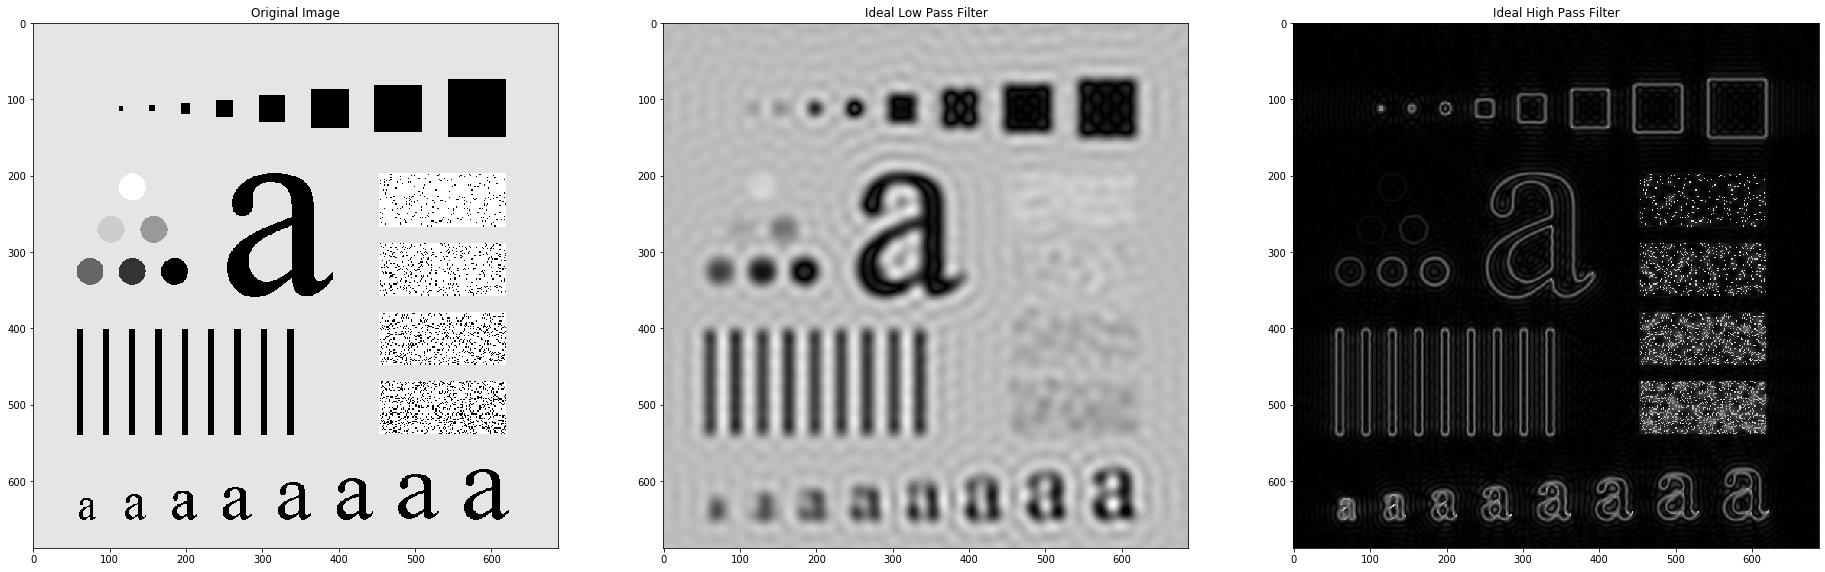

In [99]:
plt.figure(figsize=(6.4*5, 4.8*5), constrained_layout=False)
plt.subplot(131), plt.imshow(img, "gray"), plt.title("Original Image")
plt.subplot(132), plt.imshow(np.abs(inverse_LowPass), "gray"), plt.title("Ideal Low Pass Filter")
plt.subplot(133), plt.imshow(np.abs(inverse_HighPass),"gray" ), plt.title("Ideal High Pass Filter")

fig.tight_layout()
plt.show()

Unlike an ideal filter, a Butterworth filter does not have a sharp discontinuity that gives a clear cutoff between passed and filtered frequencies. And Gaussian filter is a even smoother cutoff version than Butterworth.
https://hicraigchen.medium.com/digital-image-processing-using-fourier-transform-in-python-bcb49424fd82

The reason for doing the filtering in the frequency domain is generally because it is computationally faster to perform two 2D Fourier transforms and a filter multiply than to perform a convolution in the image (spatial) domain